These are the steps to install the MNIST dataset from kaggle.

This Notebook follows three main parts:



1.   The data preparation

2.   The CNN modeling and evaluation

3.   The results prediction and submission




In [2]:
#!pip install kaggle

In [8]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#!cp /content/gdrive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json


In [10]:
#!kaggle competitions download -c digit-recognizer -p /content/kaggle

 81% 59.0M/73.2M [00:00<00:00, 190MB/s]
100% 73.2M/73.2M [00:00<00:00, 206MB/s]
 68% 33.0M/48.8M [00:00<00:00, 70.4MB/s]
100% 48.8M/48.8M [00:00<00:00, 139MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 95.7MB/s]


The dataset is now available to use and now we will extract the csv files.



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [0]:
train=pd.read_csv("/content/kaggle/train.csv")
test=pd.read_csv("/content/kaggle/test.csv")

Now we will see the datasets.

In [0]:
train.head()


In [0]:
test.head()

Now we will analyse the data.

In [0]:
train.isnull().sum(axis=0)

The above analysis shows that there are no NAN value in train dataset. Now we'll separate labels with rest of the dataset.





In [0]:
Y=train["label"]
X=train.drop("label",axis=1)

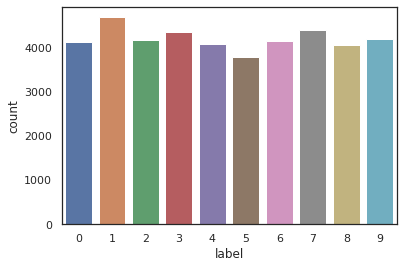

In [17]:
g = sns.countplot(Y)

### **Normalisation**

In [0]:
X/=255
test/=255

### **Reshape**

In [0]:
X=X.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

The train and test images (28pxX28px) have been represented as pandas.Dataframe as 1D vectors of 784 pixels. We reshaped all the data into 28X28X1 3D matrices.

### **Label Encoding**

In [0]:
Y=to_categorical(Y,num_classes=10)

### **Split training and valdiation set**

In [0]:
X_train, X_val, y_train, y_val =train_test_split(X,Y,test_size=0.1)

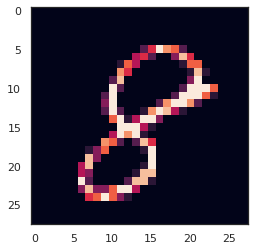

In [22]:
g=plt.imshow(X_train[0][:,:,0])

In [23]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# **CNN**

## Define the model

input layer->convolutional layer -> maxpool layer ->Flatten layer-> dense layer ->dense layer->output layer




In [24]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

## Compile the model

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Data Augmentation

In [0]:
#In keras/preprocessing/images
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Fit the model

In [35]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 25, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] 
                              )

Epoch 1/1
 - 3703s - loss: 0.0195 - acc: 0.9941 - val_loss: 0.0417 - val_acc: 0.9919


## Predict

In [38]:
y_pred = model.predict(X_val)
y_pred_actual=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
cnf=confusion_matrix(y_true,y_pred_actual)
cnf

array([[408,   0,   1,   0,   0,   0,   2,   0,   0,   0],
       [  0, 482,   0,   2,   0,   0,   0,   1,   0,   0],
       [  0,   0, 403,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 415,   0,   1,   0,   0,   2,   0],
       [  0,   0,   0,   0, 451,   0,   1,   0,   2,   7],
       [  0,   0,   0,   0,   0, 369,   1,   0,   1,   1],
       [  0,   1,   0,   0,   0,   3, 408,   0,   1,   0],
       [  0,   0,   3,   0,   0,   0,   0, 442,   1,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0, 381,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   0, 407]])

In [0]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

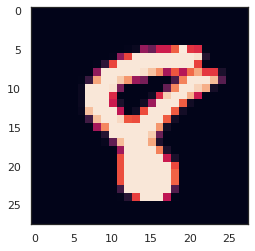

In [42]:
g=plt.imshow(test[54][:,:,0])

In [43]:
results[54]

8